In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
# import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.utils.data as data

from PIL import Image
import numpy as np
import shutil
import datetime

import matplotlib.pyplot as plt

from bat_seg_models import ThreeLayerSemSegNetWideView, UNET, UNETTraditional
from bat_seg_models import ThreeLayerSemSegNetWideViewHighDim

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
import glob
import os 
import cv2
    
class SegmentationDataset(data.Dataset):
    def __init__(self, folder_paths, transform=None, keep_orig=False, max_num_examples=None):
        """
        Args:
            folder_paths (list): list of paths each contains .jpg image files in a folder clled 'images'
                and in folder called 'masks' .png masks
            transform (callable, optional): Optional transforms to be applied on a sample
            keep_orig: keep un-transformed image
            max_num_examples: how many examples to used from folder, if None read all
        """
        self.mask_files = []
        self.img_files = []
        self.keep_orig = keep_orig
        self.num_examples = 0
            
        for folder_path in folder_paths:
            possible_img_files = glob.glob(os.path.join(folder_path, 'images', '*.jpg'))
            print('{} possible files found'.format(len(possible_img_files)))
            if self.num_examples is None:
                self.num_examples += len(possible_img_files)
            for img_num, img_path in enumerate(possible_img_files):
                if not max_num_examples:
                    self._add_annotation(folder_path, img_path)
                else:
                    if self.num_examples < max_num_examples:
                        self._add_annotation(folder_path, img_path)
                    else:
                        break
            
        self.transform = transform
        
    def _add_annotation(self, folder_path, img_path):
            mask_name = os.path.splitext(os.path.basename(img_path))[0]
            self.mask_files.append(os.path.join(folder_path, 'masks', mask_name + '.png'))
            self.img_files.append(img_path)
            self.num_examples += 1
                                   
    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            sample = {'image': image[2:-2, 2:-2], 'mask': mask[2:-2, 2:-2]}
            if self.keep_orig:
                sample['orig'] = image
            
            if self.transform:
                sample = self.transform(sample)
            return sample

    def __len__(self):
        return len(self.img_files)

In [4]:
import imgaug as ia
import imgaug.augmenters as iaa

class MaskRandomCrop:
    """Rotate by one of the given angles."""

    def __init__(self, crop_size):
        # size of square crop
        self.crop_size = crop_size

    def __call__(self, sample):
        im = sample['image']
        mask = sample['mask']

        im_height = im.shape[0]
        im_width = im.shape[1]
        top = np.random.randint(im_height - self.crop_size)
        left = np.random.randint(im_width - self.crop_size)

        im_crop = im[top:top+self.crop_size, left:left+self.crop_size]
        mask_crop = mask[top:top+self.crop_size, left:left+self.crop_size]
        
        sample['image'] = im_crop
        sample['mask'] = mask_crop

        return sample
    
class MaskImgAug:
    
    def __init__(self):
        # size of square crop
        self.transform = iaa.Sequential([
#             iaa.AdditiveGaussianNoise(scale=(0, 0.1*255)),
            iaa.Sometimes(0.4, iaa.blur.GaussianBlur(sigma=(0.0, 6.0))),
            iaa.Sometimes(0.4, iaa.AdditivePoissonNoise((0, 30)))
        ])

    def __call__(self, sample):
        im = sample['image'].astype(np.uint8)
        im_transform = self.transform(image=np.array(im))
        sample['image'] = im_transform.astype(float)
        
        return sample
    
class Mask2dMultiplyAndAddToBrightness():
    def __init__(self, add, multiply):
        """Add and multiply image values by given amount randomly within range.
        
        Expects image to be between 0 and 255.
        
        Args:
            add: either number of tuple, if tuple randomly choose from range
            multiply: either number ot tuple, if tuple randomly choose from range
        """
        self.add = add
        self.multiply = multiply
        self.rng = np.random.default_rng()
        
    def __call__(self, sample):
        im = sample['image'].astype(np.float64)
        if isinstance(self.add, tuple):
            add_val = self.rng.uniform(self.add[0], self.add[1])
        else:
            add_val = self.add
        if isinstance(self.multiply, tuple):
            multiply_val = self.rng.uniform(self.multiply[0], self.multiply[1])
        else:
            multiply_val = self.multiply
        im += add_val
        im *= multiply_val
        im = np.maximum(im, 0)
        im = np.minimum(im, 255)
        
        sample['image'] = im
        
        return sample
    
    
class MaskToTensor:
    def __call__(self, sample):
        im = sample['image']
        mask = sample['mask']
        
        im_tensor = torch.from_numpy(im).float() / 255
        im_tensor = torch.unsqueeze(im_tensor, 0)
        mask_tensor = torch.from_numpy(np.array(mask, np.int64, copy=False))
        mask_tensor = mask_tensor // 255
        
        sample['image'] = im_tensor
        sample['mask'] = mask_tensor
        
        return sample
    
class Mask3dto2d:
    """ Expects images of size NxMxC"""
    def __init__(self, channel_to_use):
        self.channel_to_use = channel_to_use
    
    def __call__(self, sample):
        im = sample['image']
        sample['image'] = im[..., self.channel_to_use]
       
        return sample
    
class MaskCompose:
    def __init__(self, transform_list):
        """Chain together transforms in transform.
         Expect transform on both image and mask in dict
         
         Args:
             transform_list (list): list of custom augmentations
         """
        self.transform_list = transform_list
    
    def __call__(self, sample):
        for transform in self.transform_list:
            sample  = transform(sample)
        return sample
    
class MaskNormalize:
    def __init__(self, mean, std):
        """Normalize image, leave mask unchanged"""
        self.mean = mean
        self.std = std
        
    def __call__(self, sample):
        im = sample['image']
        im_norm = TF.normalize(im, self.mean, self.std)
        
        sample['image'] = im_norm
        return sample
    
class MaskContrast:
    def __init__(self, contrast_factor):
        """Change image contrast, leave mask unchanged
        
        Args:
            contrast_factor: single value or tuple"""
        self.contrast_factor = contrast_factor
        self.rng = np.random.default_rng()

    def __call__(self, sample):
        im = sample['image']
        if isinstance(self.contrast_factor, tuple):
            contrast_factor = self.rng.uniform(self.contrast_factor[0], self.contrast_factor[1])
        else:
            contrast_factor = self.contrast_factor
        im_height, im_width = im.shape
        aprox_mean = np.mean([im[0,0], im[-1, 0], im[0, -1], im[-1, -1], 
                              im[im_height//2, im_width//2], im[-im_height//2, -im_width//2]])
        im_contrast = aprox_mean + contrast_factor * (im - aprox_mean)
        im_contrast = np.maximum(im_contrast, 0)
        im_contrast = np.minimum(im_contrast, 255)
        sample['image'] = im_contrast
        return sample
    
class MaskCenterImage:
    def __init__(self):
        pass
    def __call__(self, sample):
        im = sample['image']
        mean = np.mean(im[::10, ::10])
        bias = 125 - int(mean)
        bias = np.max([0, bias])
        sample['image'] += bias
        sample['image'] = np.where(sample['image'] > 255, 255, sample['image'])
        return sample

        

In [6]:
small_folder = ".../kasanka-bats/annotations/subset200"
# root_train_folder = small_folder

In [7]:
def get_conf_matrix(conf_matrix, num_classes, pred_batch, mask_batch):
    """ Calculate confusion matrix and add to passed confusion matrix.
    
    Args:
        conf_matrix (np array): confusion matrix size 
            (num_classes + 1, num_classes + 1)
        num_classes (int): number of classes being segmented
        pred_batch (np array): NxM or BxNxM
        mask_batch (np array): NxM or BxNxM
    """
    
    N = num_classes + 1

    if len(pred_batch.shape) == 2:
        pred_batch = np.expand_dims(pred_batch, 0)
        mask_batch = np.expand_dims(mask_batch, 0)
    for pred, mask in zip(pred_batch, mask_batch):
        conf_matrix += np.bincount(
            N * pred.reshape(-1) + mask.reshape(-1), minlength=N ** 2
        ).reshape(N, N)
    return conf_matrix

def evaluate(num_classes, conf_matrix):
    """ Caclculate Accuracy and IOU scores.
    
    Args:
        num_classes (int): num classes
        conf_matrix (np array): confusion matrix of size 
            (num_classes + 1, num_classes + 1)
    """
    acc = np.full(num_classes, np.nan, dtype=np.float)
    iou = np.full(num_classes, np.nan, dtype=np.float)
    tp = conf_matrix.diagonal()[:-1].astype(np.float)
    pos_gt = np.sum(conf_matrix[:-1, :-1], axis=0).astype(np.float)
    class_weights = pos_gt / np.sum(pos_gt)
    pos_pred = np.sum(conf_matrix[:-1, :-1], axis=1).astype(np.float)
    acc_valid = pos_gt > 0
    acc[acc_valid] = tp[acc_valid] / pos_gt[acc_valid]
    iou_valid = (pos_gt + pos_pred) > 0
    union = pos_gt + pos_pred - tp
    iou[acc_valid] = tp[acc_valid] / union[acc_valid]
    macc = np.sum(acc[acc_valid]) / np.sum(acc_valid)
    miou = np.sum(iou[acc_valid]) / np.sum(iou_valid)
    fiou = np.sum(iou[acc_valid] * class_weights[acc_valid])
    pacc = np.sum(tp) / np.sum(pos_gt)
    
    return iou, acc

import time
# def train(model, num_classes, train_dl, val_dl, loss_fn, optimizer, model_file,
#           acc_fn, epochs=1, accumulation_steps=1, val_epoch=1, show_images=False):
#     start = time.time()
    
#     train_loss, valid_loss = [], []
    
#     # calc max usuable batchnum
#     max_batchnum = ((len(train_dl) // accumulation_steps) 
#                     * accumulation_steps)
#     print("using {} batches ({} images)".format(
#         max_batchnum, max_batchnum * train_dl.batch_size))
    
#     model.cuda()

#     for epoch in range(epochs):
        
#         if epoch % 1 == 0:
#             print('Epoch {}/{}'.format(epoch, epochs - 1))
#         if epoch % 10 == 0:
#             torch.save(model.state_dict(), '{}_epoch_{}.tar'.format(model_file, epoch))
        
#         optimizer.zero_grad()
        
#         for phase in ['train', 'val']:
#             phase_start = time.time()
#             if phase == 'train':
#                 model.train(True)
#                 dataloader = train_dl
#             else:
#                 if epoch % val_epoch != 0:
#                     continue
#                 model.train(False)
#                 dataloader = val_dl
#                 conf_matrix = np.zeros((num_classes+1, num_classes+1), dtype=np.int64)
                
#             running_loss = 0.0
#             running_acc = 0.0
            
#             step = 0
            
            
            
#             # iterate over data
#             for batch_ind, batch in enumerate(dataloader):
#                 if batch_ind >= max_batchnum:
#                     break
#                 im_batch = batch['image'].cuda()
#                 masks = batch['mask'].cuda()
                
#                 if phase == 'train':
#                     outputs = model(im_batch)
#                     loss = loss_fn(outputs, masks)
#                     loss.backward()
#                     if (batch_ind+1) % accumulation_steps == 0:
#                         # Wait for several backward steps
#                         # Now we can do an optimizer step
#                         optimizer.step()                            
#                         model.zero_grad() 
#                 else:
#                     with torch.no_grad():
#                         outputs = model(im_batch)
#                         loss = loss_fn(outputs, masks)
#                         np_outputs = outputs.cpu().numpy()
#                         np_preds = np.argmax(np_outputs, axis=1)
#                         np_masks = masks.cpu().numpy()
#                         conf_matrix = get_conf_matrix(conf_matrix, num_classes, 
#                                                       np_preds, np_masks)
                        
#                 if show_images:
#                     np_im_batch = batch['image'].numpy()
#                     for im in np_im_batch:
#                         plt.figure()
#                         plt.imshow(np.squeeze(im))
#                         plt.title(phase)

#                 running_loss += loss.item()*dataloader.batch_size
                
                
#                 step += 1
                
#             epoch_loss = running_loss / len(dataloader.dataset)
#             if epoch % 1 == 0:
                
#                 phase_length = time.time() - phase_start
#                 fps =  (len(dataloader) * len(batch)) / phase_length
                
#                 print('{} Loss: {:.4f}  AllocMem (Mb): {:.3f} MaxMem(Mb) {:.3f}Time: {:.3f} fps: {:.3f}'.format(
#                     phase, epoch_loss, torch.cuda.memory_allocated()/1024/1024, 
#                     torch.cuda.max_memory_allocated()/1024/1024, phase_length, fps))
#             if phase == 'val':
#                 iou, acc = evaluate(num_classes, conf_matrix)
#                 print('IOU: {}, Acc: {}'.format(iou, acc))
#             train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

#         time_elapsed = time.time() - start   

#     return train_loss, valid_loss 
    
def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

def train(model, num_classes, train_dl, val_dl, loss_fn, optimizer, 
          acc_fn, epochs=1, lr_scheduler=None, save_best_val=False,
          model_file='model.tar', accumulation_steps=1, val_epoch=1, 
          show_images=False):
    start = time.time()
    
    train_loss, valid_loss = [], []
    
    # calc max usuable batchnum
    max_batchnum = ((len(train_dl) // accumulation_steps) 
                    * accumulation_steps)
    print("using {} batches ({} images)".format(
        max_batchnum, max_batchnum * train_dl.batch_size))
    
    model.cuda()
    
    top_val_loss = 100000000000

    for epoch in range(epochs):
        
        if epoch % 1 == 0:
            print('Epoch {}/{}'.format(epoch, epochs - 1))
        
        optimizer.zero_grad()
        
        for phase in ['train', 'val']:
            phase_start = time.time()
            if phase == 'train':
                model.train(True)
                dataloader = train_dl
            else:
                if epoch % val_epoch != 0:
                    continue
                model.train(False)
                dataloader = val_dl
                conf_matrix = np.zeros((num_classes+1, num_classes+1), dtype=np.int64)
                
            running_loss = 0.0
            running_acc = 0.0
            
            step = 0
            
            
            
            # iterate over data
            for batch_ind, batch in enumerate(dataloader):
                if batch_ind >= max_batchnum:
                    break
                im_batch = batch['image'].cuda()
                masks = batch['mask'][:, 24:-24, 24:-24].cuda()
#                 print(batch['image'].size(), batch['mask'][46:-46, 46:-46].shape)
                
                if phase == 'train':
                    outputs = model(im_batch)
                    loss = loss_fn(outputs, masks)
                    loss.backward()
                    if (batch_ind+1) % accumulation_steps == 0:
                        # Wait for several backward steps
                        # Now we can do an optimizer step
                        optimizer.step()
                        if lr_scheduler:
                            lr_scheduler.step()
                        model.zero_grad() 
                else:
                    with torch.no_grad():
                        outputs = model(im_batch)
                        loss = loss_fn(outputs, masks)
                        np_outputs = outputs.cpu().numpy()
                        np_preds = np.argmax(np_outputs, axis=1)
                        np_masks = masks.cpu().numpy()
                        conf_matrix = get_conf_matrix(conf_matrix, num_classes, 
                                                      np_preds, np_masks)
                        
                if show_images:
                    np_im_batch = batch['image'].numpy()
                    for im in np_im_batch:
                        plt.figure()
                        plt.imshow(np.squeeze(im))
                        plt.title(phase)

                running_loss += loss.item()*dataloader.batch_size
                
                
                step += 1
                
            epoch_loss = running_loss / len(dataloader.dataset)
            if epoch % 1 == 0:
                
                phase_length = time.time() - phase_start
                fps =  (len(dataloader) * len(batch)) / phase_length
                
                print('{} Loss: {:.4f}  AllocMem (Mb): {:.3f} MaxMem(Mb) {:.3f}Time: {:.3f} fps: {:.3f}'.format(
                    phase, epoch_loss, torch.cuda.memory_allocated()/1024/1024, 
                    torch.cuda.max_memory_allocated()/1024/1024, phase_length, fps))
            if phase == 'val':
                valid_loss.append(epoch_loss)
                if epoch_loss < top_val_loss:
                    top_val_loss = epoch_loss
                    if save_best_val:
                        torch.save(model.state_dict(), model_file)
                        print('saved new model. val loss {}'.format(epoch_loss))
                    
                iou, acc = evaluate(num_classes, conf_matrix)
                print('IOU: {}, Acc: {}'.format(iou, acc))
            else:
                train_loss.append(epoch_loss) 

        time_elapsed = time.time() - start   

    return train_loss, valid_loss 

In [8]:
channel = 2

im_size = 1024 #532

none_data_transforms = torchvision.transforms.Compose([
                                                        Mask3dto2d(channel),
                                                        MaskRandomCrop(im_size),
                                                        MaskToTensor(), 
                                                        MaskNormalize(mean[channel]/255, std[channel]/255)])

easy_data_transforms = torchvision.transforms.Compose([
                                                        Mask3dto2d(channel),
                                                        MaskRandomCrop(im_size),
                                                        Mask2dMultiplyAndAddToBrightness(
                                                                multiply=(0.5, 1.2), add=(-50, 0)),
                                                        MaskContrast(contrast_factor=(0.6, 1.3)),
                                                        MaskImgAug(),
                                                        MaskToTensor(), 
                                                        MaskNormalize(mean[channel]/255, std[channel]/255)])

hard_data_transforms = torchvision.transforms.Compose([
                                                        Mask3dto2d(channel),
                                                        MaskRandomCrop(im_size),
                                                        Mask2dMultiplyAndAddToBrightness(
                                                                multiply=(0.1, 1.2), add=(-50, 0)),
                                                        MaskContrast(contrast_factor=(0.3, 1.3)),
                                                        MaskImgAug(),
                                                        MaskToTensor(), 
                                                        MaskNormalize(mean[channel]/255, std[channel]/255)])

# train_data_transforms = torchvision.transforms.Compose([
#                                                         Mask3dto2d(channel),
#                                                         MaskRandomCrop(1024),
#                                                         MaskToTensor(), 
#                                                         MaskNormalize(mean[channel], std[channel])])


visualize_data_transforms = torchvision.transforms.Compose([
                                                            Mask3dto2d(channel),
                                                            MaskRandomCrop(im_size),
                                                            MaskToTensor(),
                                                            MaskNormalize(mean[channel]/255, std[channel]/255)
                                                           ])



val_data_transforms = torchvision.transforms.Compose([
                                                      Mask3dto2d(channel),
                                                      MaskRandomCrop(im_size), 
                                                      MaskToTensor(), 
                                                      MaskNormalize(mean[channel]/255, std[channel]/255)])

In [9]:
def worker_init_fn(worker_id):

    np.random.seed(datetime.datetime.now().microsecond + worker_id * 1000000)
#     ia.seed(np.random.get_state()[1][0] + worker_id)


batch_size = 4 #was 4

train_dataset_no_aug = SegmentationDataset(
    [root_train_folder], none_data_transforms, max_num_examples=None)
train_dataloader_no_aug = data.DataLoader(train_dataset_no_aug, batch_size=batch_size,
                                   shuffle=True, num_workers=7, pin_memory=True,
                                   worker_init_fn=worker_init_fn)

train_dataset_easy_aug = SegmentationDataset(
    [root_train_folder], easy_data_transforms, max_num_examples=None)
train_dataloader_easy_aug = data.DataLoader(train_dataset_easy_aug, batch_size=batch_size,
                                   shuffle=True, num_workers=7, pin_memory=True,
                                   worker_init_fn=worker_init_fn)

train_dataset_hard_aug = SegmentationDataset(
    [root_train_folder], hard_data_transforms, max_num_examples=None)
train_dataloader_hard_aug = data.DataLoader(train_dataset_hard_aug, batch_size=batch_size,
                                   shuffle=True, num_workers=7, pin_memory=True,
                                   worker_init_fn=worker_init_fn)
visualize_dataset = SegmentationDataset([root_train_folder], visualize_data_transforms)

val_dataset = SegmentationDataset(
    [root_val_folder], hard_data_transforms, max_num_examples=None)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size,
                                 shuffle=False, num_workers=7, pin_memory=True,
                                 worker_init_fn=worker_init_fn)

raw_dataset = SegmentationDataset([root_train_folder])

4500 possible files found
4500 possible files found
4500 possible files found
4500 possible files found
898 possible files found
4500 possible files found


In [10]:
print('image', train_dataset_no_aug[0]['image'].shape)
print('mask', train_dataset_no_aug[0]['mask'].shape)

image torch.Size([1, 532, 532])
mask torch.Size([532, 532])


In [11]:
len(train_dataset_no_aug)

4500

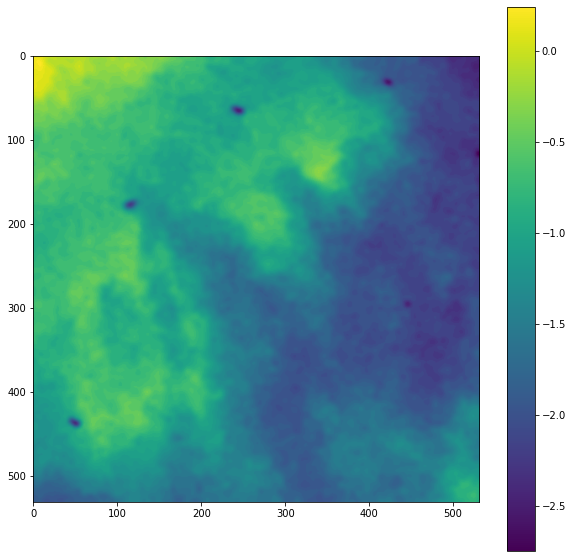

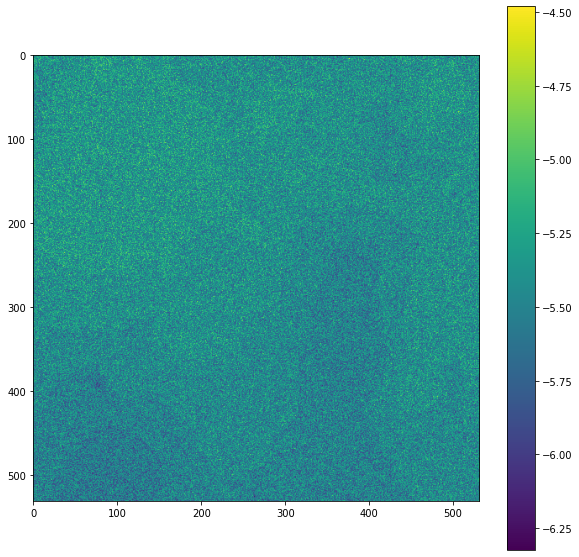

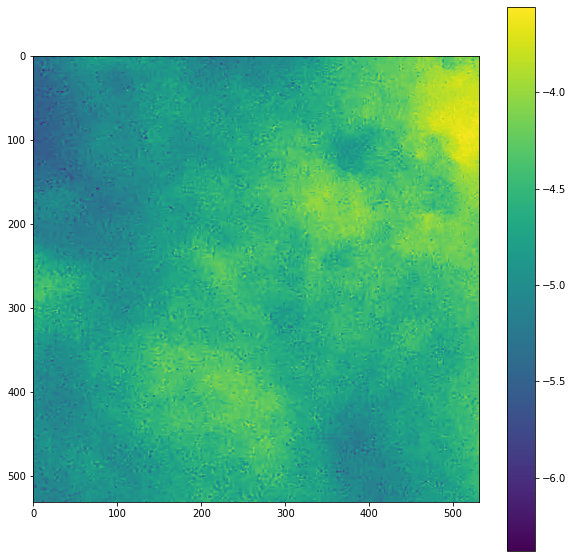

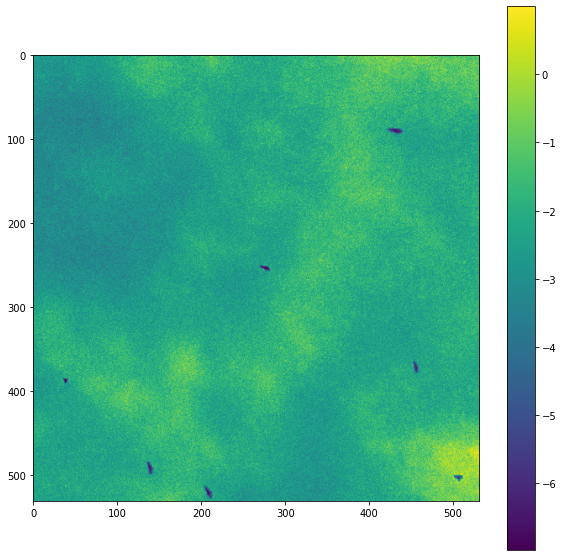

In [12]:
# for ind in np.linspace(0, len(visualize_dataset), 5, dtype=int, endpoint=False):
# for ind in np.random.choice(len(visualize_dataset), 5):
for ind in range(4):
    
    sample = train_dataset_hard_aug[ind]
    im = sample['image'].numpy()
    mask = sample['mask'].numpy()
    im = np.squeeze(im)
    if len(im.shape) == 3:
        im = np.transpose(im, (1, 2, 0))
#     plt.figure(figsize=(10,10))
#     plt.imshow(im, vmin=0, vmax=1.0)
#     plt.colorbar()
    plt.figure(figsize=(10,10))
    plt.imshow(im)
    plt.colorbar()

In [13]:
class DoubleCNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.name = 'DoubleCNNBlock'
        
        self.block = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, 
                            stride=1, padding=padding),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, 
                            stride=1, padding=padding),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        return self.block(x)

class ContractBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.name = "ContractBlock"
        
        self.maxpool_conv = nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            DoubleCNNBlock(in_channels, out_channels, kernel_size, padding)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)
    
class ExpandBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.name = "ExpandBlock"
        
        self.expand = torch.nn.ConvTranspose2d(in_channels, in_channels//2, 
                                               kernel_size=3, stride=2, 
                                               padding=1, output_padding=1
                                              )
        self.conv = DoubleCNNBlock(in_channels, out_channels, kernel_size, padding)
        
    def forward(self, x1, x2):
        x1_expand = self.expand(x1)
        # Assumes dims have been corrected/padded to match elsewhere
        x = torch.cat([x1_expand, x2], dim=1)
        return self.conv(x)
    
    
class UNETShortened(nn.Module):
    def __init__(self, in_channels, out_channels, should_pad=True):
        super().__init__()
        self.name = 'UNETTraditional'
        if should_pad:
            conv1_pad = 3
            gen_pad = 1
        else:
            conv1_pad = 0
            gen_pad = 0
        self.conv1 = DoubleCNNBlock(in_channels, 32, 7, conv1_pad)
        self.conv2 = ContractBlock(32, 64, 3, gen_pad)
        self.conv3 = ContractBlock(64, 128, 3, gen_pad)

        self.upconv1 = ExpandBlock(128, 64, 3, gen_pad)
        self.upconv2 = ExpandBlock(64, 32, 3, gen_pad)
        
        self.outconv = nn.Conv2d(32, out_channels, kernel_size=1)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        
        conv2_crop = 4
        cropped_conv2 = conv2[:, :, conv2_crop:-conv2_crop, conv2_crop:-conv2_crop]
        upconv1 = self.upconv1(conv3, cropped_conv2)
        conv1_crop = 16
        cropped_conv1 = conv1[:, :, conv1_crop:-conv1_crop, conv1_crop:-conv1_crop]
        upconv2 = self.upconv2(upconv1, cropped_conv1)
        
        outconv = self.outconv(upconv2)
        xout = self.softmax(outconv)

        return xout

In [14]:
# model = SimpleSemSegNet(3, 2)
# model = SuperSimpleSemSegNet(3, 2)
# model = ThreeLayerSemSegNet(1, 2)
# model = ThreeLayerSemSegNetWideViewHighDim(1, 2)
# model = FourLayerSemSegNetWideView(1, 2)
# model = UNET(1, 2, should_pad=False)
model = UNETTraditional(1, 2, should_pad=False)
model

UNETTraditional(
  (conv1): DoubleCNNBlock(
    (block): Sequential(
      (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv2): ContractBlock(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleCNNBlock(
        (block): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (4): ReLU()
          (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )


In [15]:
lr = .01
accumulation_steps = 4
epochs = 100 #0
momentum = 0.9
model_name = "UNETTraditional"
aug_type = "better-norm-aug-2d-20Nov-big-dataset"

folder = './models'
os.makedirs(folder, exist_ok=True)

model_name = 'model_{}_epochs_{}_batcheff_{}_lr_{}_momentum_{}_aug_{}'.format(
    model_name, epochs, accumulation_steps*batch_size, lr, momentum, aug_type)

model_file = os.path.join(folder, model_name + '.tar')

In [16]:
def lr_scheduler(epoch):
    """ To pass to torch optim lr_scheduler.
    
    Args:
        epoch: current epoch number
        
    return number to multiply base lr
    """
    
    if epoch < 15:
        return 1.0
    elif epoch < 30:
        return 0.2
    else:
        return 0.05


optimizer_none = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler_none = torch.optim.lr_scheduler.LambdaLR(optimizer_none, lr_scheduler, last_epoch=-1)

optimizer_easy = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler_easy = torch.optim.lr_scheduler.LambdaLR(optimizer_easy, lr_scheduler, last_epoch=-1)

optimizer_hard = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler_hard = torch.optim.lr_scheduler.LambdaLR(optimizer_hard, lr_scheduler, last_epoch=-1)

using 1124 batches (4496 images)
Epoch 0/0
train Loss: 0.0734  AllocMem (Mb): 25.076 MaxMem(Mb) 3074.730Time: 288.486 fps: 7.799
val Loss: 2.0605  AllocMem (Mb): 16.513 MaxMem(Mb) 3074.730Time: 21.710 fps: 20.728
saved new model. val loss 2.0604562261919668
IOU: [0.48285155 0.00454425], Acc: [0.48290558 0.95475288]
using 1124 batches (4496 images)
Epoch 0/29
train Loss: 0.0547  AllocMem (Mb): 27.438 MaxMem(Mb) 3076.878Time: 295.634 fps: 7.611
val Loss: 0.3240  AllocMem (Mb): 18.661 MaxMem(Mb) 3076.878Time: 26.735 fps: 16.832
saved new model. val loss 0.3239877848556153
IOU: [0.84642101 0.01354047], Acc: [0.84664554 0.88825861]
Epoch 1/29
train Loss: 0.0397  AllocMem (Mb): 27.438 MaxMem(Mb) 3076.878Time: 295.587 fps: 7.612
Epoch 2/29
train Loss: 0.0339  AllocMem (Mb): 27.438 MaxMem(Mb) 3076.878Time: 296.782 fps: 7.581
val Loss: 0.1400  AllocMem (Mb): 18.661 MaxMem(Mb) 3076.878Time: 22.599 fps: 19.913
saved new model. val loss 0.14004626006867016
IOU: [0.97678161 0.08256705], Acc: [0.977

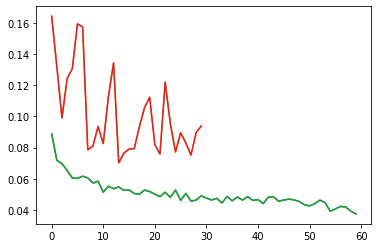

In [17]:
total_train_loss = []
total_val_loss = []

no_aug_epochs = 1
easy_epochs = 30
hard_epochs = 60


# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.NLLLoss(weight=torch.tensor([.01, .99]).cuda())
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

train_loss, val_loss = train(model, 2, train_dataloader_no_aug, val_dataloader,
                            loss_fn, optimizer_none, acc_metric, epochs=no_aug_epochs, 
                             accumulation_steps=accumulation_steps, val_epoch=1,
                             lr_scheduler=scheduler_none, save_best_val=True,
                             model_file=model_file, show_images=False)
total_train_loss.extend(train_loss)
total_val_loss.extend(val_loss)

train_loss, val_loss = train(model, 2, train_dataloader_easy_aug, val_dataloader,
                            loss_fn, optimizer_easy, acc_metric, epochs=easy_epochs, 
                             accumulation_steps=accumulation_steps, val_epoch=2,
                             lr_scheduler=scheduler_easy, save_best_val=True,
                             model_file=model_file, show_images=False)
total_train_loss.extend(train_loss)
total_val_loss.extend(val_loss)

train_loss, val_loss = train(model, 2, train_dataloader_hard_aug, val_dataloader,
                            loss_fn, optimizer_hard, acc_metric, epochs=hard_epochs, 
                             accumulation_steps=accumulation_steps, val_epoch=2,
                             lr_scheduler=scheduler_hard, save_best_val=True,
                             model_file=model_file, show_images=False)
total_train_loss.extend(train_loss)
total_val_loss.extend(val_loss)

plt.plot(train_loss[:])
plt.plot(val_loss[:])

save_model = True

if save_model:
    torch.save(model.state_dict(), model_file)
    
import matplotlib.pyplot as plt
plt.plot(train_loss[:])
plt.plot(val_loss[:])

In [43]:
torch.save(model.state_dict(), model_file)

In [18]:
model_file

'./models/model_UNETTraditional_epochs_10_batcheff_16_lr_0.01_momentum_0.9_aug_better-norm-aug-2d-20Nov-big-dataset.tar'

In [ ]:
old_train_loss = np.copy(train_loss)

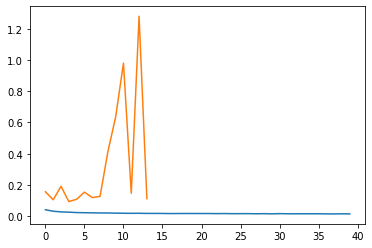

In [48]:
plt.plot(train_loss[:])
plt.plot(val_loss[:])

In [19]:
model_file

'./models/model_UNETTraditional_epochs_10_batcheff_16_lr_0.01_momentum_0.9_aug_better-norm-aug-2d-20Nov-big-dataset.tar'

In [39]:
model_filename = 'model_ThreeLayerWide_epochs_10_batcheff_4_lr_0.05_momentum_0.5_aug_aug-no-blur-2d-17Nov-big-dataset.tar'
model_file = os.path.join(folder, model_filename)

In [20]:
model_file

'./models/model_UNETTraditional_epochs_100_batcheff_16_lr_0.01_momentum_0.9_aug_better-norm-aug-2d-20Nov-big-dataset.tar'

4

In [18]:
batch_size = 1
test_data_transforms = torchvision.transforms.Compose([
                                                        Mask3dto2d(channel),
#                                                         MaskRandomCrop(532),
                                                        MaskToTensor(), 
                                                        MaskNormalize(mean[channel]/255, std[channel]/255)
                                                        ]
                                                     )
test_dataset = SegmentationDataset([root_test_folder], test_data_transforms, keep_orig=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=7, pin_memory=True, worker_init_fn=worker_init_fn)

20 possible files found


In [17]:
for i in test_dataloader:
    break
print(i['image'].min())

tensor(-6.0529)


In [18]:
y = 0
for x in test_dataloader:
    y = x
    break

In [34]:
model_file

'./models/model_UNET_epochs_100_batcheff_16_lr_0.01_momentum_0.9_aug_better-norm-aug-2d-20Nov-big-dataset.tar'

In [15]:
mem_params = sum([param.nelement()*param.element_size() for param in model.parameters()])
mem_bufs = sum([buf.nelement()*buf.element_size() for buf in model.buffers()])
mem = mem_params + mem_bufs # in bytes
print(mem)

2248024


In [1]:
loss_fn = torch.nn.NLLLoss(weight=torch.tensor([.08, .92]).cuda())
should_plot = True
def acc_metric_cpu(predb, yb):
    return (np.mean(np.argmax(predb, axis=1) == yb).astype(float))

def logit2prob(logit):
    e_l = np.e ** logit
    return e_l 

def rescale(im):
    im -= im.min()
    im /= im.max()
    im *= 255
    return im.astype(int)

num_classes = 2

conf_matrix = np.zeros((num_classes+1, num_classes+1), dtype=np.int64)

device = torch.device("cuda")
model = UNETTraditional(1, 2, should_pad=False)
model.load_state_dict(torch.load(model_file))
model.to(device)

model.train(False)

num_frames = 0

running_loss = 0

dataloader = test_dataloader #train_dataset_no_aug


num_batches = 10
padded_edge = 24

for batch_ind, batch in enumerate(dataloader):
    
    
    if batch_ind >= num_batches and should_plot:   
        break
        
    im_batch = batch['image'].cuda()
    masks = batch['mask'][:, padded_edge:-padded_edge, padded_edge:-padded_edge].cuda()
    
    with torch.no_grad():
        outputs = model(im_batch)
        num_frames += len(im_batch)
    loss = loss_fn(outputs, masks)
    running_loss += loss.item()*dataloader.batch_size
    
    outputs = outputs.cpu().numpy()
    preds = np.argmax(outputs, axis=1)
    masks = batch['mask'][:, padded_edge:-padded_edge, padded_edge:-padded_edge].numpy()
    
    
    
    conf_matrix = get_conf_matrix(conf_matrix, num_classes, 
                                  preds, masks)
    
    if should_plot:
        for ind in range(len(im_batch)):

            if 'orig' in batch.keys():
                plt.figure(figsize=(20,20))
                plt.imshow(batch['orig'][ind])
            plt.figure(figsize=(20,20))
            im = im_batch[ind].cpu().numpy()
            im = np.transpose(im, (1, 2, 0))
            plt.imshow(rescale(im)[padded_edge:-padded_edge, padded_edge:-padded_edge])
            
            display_im = np.zeros((masks[ind].shape[0], masks[ind].shape[1], 3))
            display_im[..., 0] = masks[ind]
#             display_im[..., 1] = logit2prob(outputs[ind,1])
            prob_bat = logit2prob(outputs[ind,1])
#             display_im[..., 1] = logit2prob(outputs[ind,1])
            display_im[..., 1] = np.where(prob_bat>.8, 1, 0)
#             display_im[..., 1] = np.argmax(outputs[ind], axis=0)

            
#             plt.colorbar()
            plt.figure(figsize=(20,20))
            plt.imshow(display_im)
                                        
                                            
#             plt.imshow(masks[ind])
#             plt.figure(figsize=(10,10))
#             plt.imshow(logit2prob(outputs[ind,1]))
#             plt.colorbar()
    
        
    
print('num_images:', num_frames)    
    
print(evaluate(num_classes, conf_matrix))
print('epoch loss {}'.format(running_loss / len(dataloader.dataset)))



# print(acc_metric_cpu(outputs, masks))


print('(array([0.89453741, 0.01963136]), array([0.89547724, 0.66801191]))')
print('(array([0.85383388, 0.00903547]), array([0.85550988, 0.40486206]))')
print('(array([0.99741196, 0.35509281]), array([0.99923319, 0.43878196]))')
print('(array([0.99821493, 0.49235221]), array([0.99971842, 0.53513952]))')
print('(array([0.99855523, 0.58660997]), array([0.99952043, 0.679801  ]))')
print('(array([0.99460785, 0.24880005]), array([0.99551585, 0.66193785]))')
print('(array([0.99841432, 0.50716247]), array([0.99947347, 0.60627301]))')
print('(array([0.97783943, 0.06026228]), array([0.97892977, 0.56061034]))')

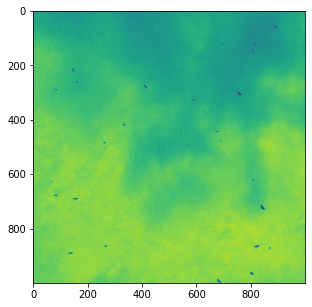

In [23]:
ind = -1
plt.figure(figsize=(5,5))
im = im_batch[ind].cpu().numpy()
im = np.transpose(im, (1, 2, 0))
plt.imshow(rescale(im[:1000, :1000]))

In [ ]:
background = []
for i in range(10):
    total = 0
    bat = 0
    for batch_ind, batch in enumerate(train_dataloader):
        mask = batch['mask'].numpy() 
        total += mask.shape[0] * mask.shape[1] * mask.shape[2]
        bat += np.sum(mask)
    background.append((total - bat) / total)
print(np.mean(np.array(background)))

In [39]:
mask.shape

torch.Size([4, 1024, 1024])

In [79]:
preds = np.argmax(outputs, axis=1)

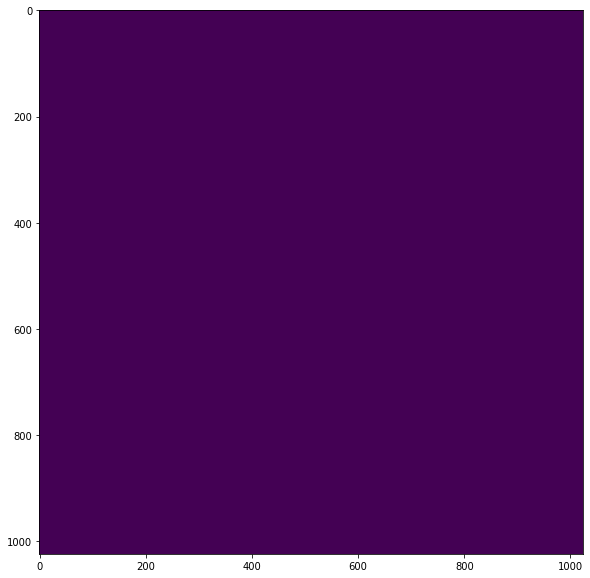

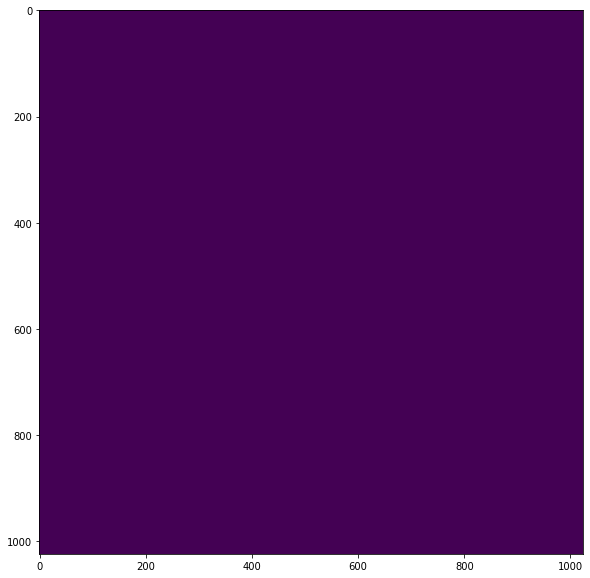

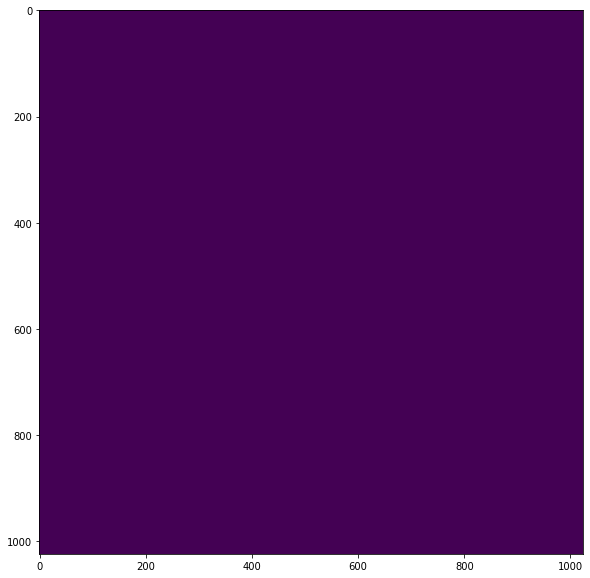

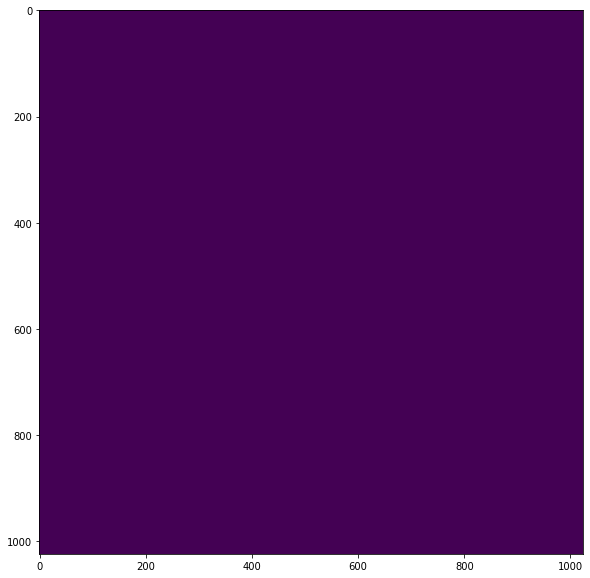

In [80]:
for pred in preds:
    plt.figure(figsize=(10,10))
    plt.imshow(pred)

In [23]:
outputs.shape

(1, 2, 1520, 2704)

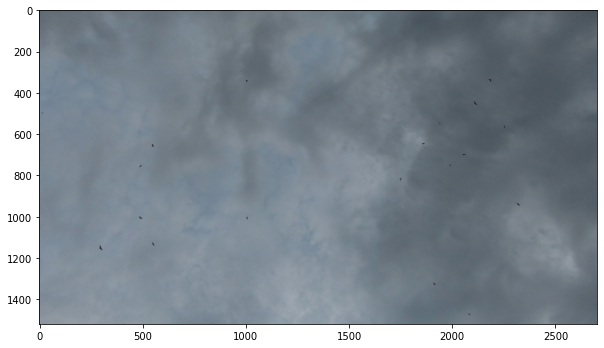

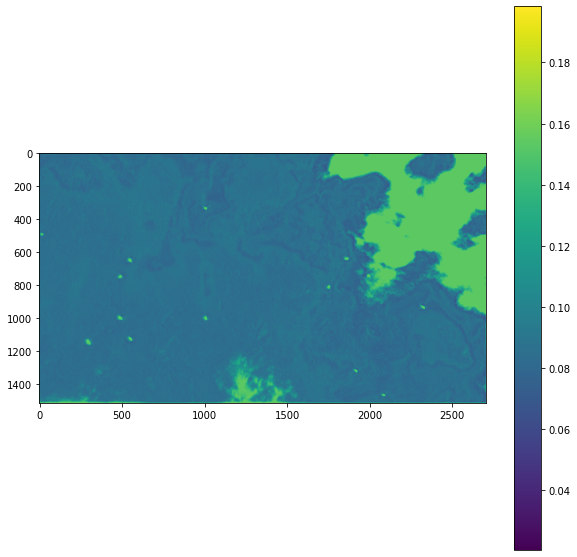

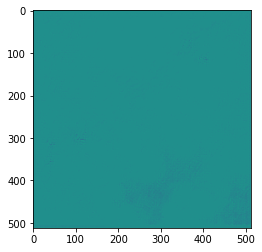

In [163]:
np_out = output.detach().numpy()
plt.imshow(np_out[0,0])

In [85]:
sample = data_loader[0]
im = sample['image']
mask = sample['mask']

In [86]:
mask = np.squeeze(np.transpose(mask.numpy(), (1, 2, 0)))
im = np.transpose(im.numpy(), (1, 2, 0))

In [87]:
mask.shape

(512, 512)

In [ ]:
print('hi')

In [15]:
random_data = torch.rand((1, 1, 28, 28))

my_nn = Net()
result = my_nn(random_data)
target = torch.randn(10)
target = target.view(1, -1)
criterion = nn.MSELoss()

loss = criterion(result, target)
print(loss)

tensor(7.1944, grad_fn=<MseLossBackward>)


In [18]:
loss.grad_fn

In [19]:
my_nn.zero_grad()

In [21]:
loss.backward()

In [23]:
optimizer = optim.SGD(my_nn.parameters(), lr=0.01)

In [24]:
optimizer.step()